In [6]:
import pandas as pd
import numpy as np

# In a nutshell

In [18]:
import pandas as pd
import numpy as np

from odat.mdat.freesounds import mk_dacc

In [19]:
dacc = mk_dacc()
len(dacc.tags)

41

In [20]:
from slang import mk_chunker
from slang.snippers import LdaChkToFv, PcaChkToFv
from slang import mk_chk_fft
from i2 import Pipe
from functools import partial

def mk_spectrizer(chk_size=2048, chk_step=None):
    chunker = mk_chunker(chk_size, chk_step)
    to_fft = mk_chk_fft(chk_size=chk_size)
    return Pipe(chunker, partial(map, to_fft))

spectrizer = mk_spectrizer()

chk, tag = next(dacc.chk_tag_pairs(wf_to_chks=spectrizer))
assert chk.shape == (1025,), f'chk does not seem to be a spectrum'


In [21]:
from slang import ClassificationSnipper
from slang.snippers import PcaChkToFv, LdaChkToFv

snipper = ClassificationSnipper(
    wf_to_chks=spectrizer,
    chk_to_fv=PcaChkToFv(n_components=73),
    fv_to_snip={'n_clusters': 41 * 5}
)

# (snipper
#     .fit_chk_to_fv(dacc.chk_tag_pairs(snipper.wf_to_chks))  # fit on (chk, tag) pairs
#     .fit_fv_to_snip(dacc.fv_tag_pairs(snipper.wf_to_chks, snipper.chk_to_fv))  # fit on (fv, tag) pairs
#     .fit_snip_to_score(  # fit on (snip tag) pairs
#         ((snipper.fv_to_snip(fv), tags) 
#              for fv, tags in dacc.fv_tag_pairs(snipper.wf_to_chks, snipper.chk_to_fv)))
# )

In [ ]:
from 

# Building up a data accessor object (`dacc`)

In [3]:
from collections import Counter
from dol import FilesOfZip
from config2py import config_getter

zip_filepath = config_getter('freesounds_audio_dataset_local_zip_filepath')
raw = FilesOfZip(zip_filepath)
len(raw)

18877

Let's poke at the list of keys:

In [4]:
print(list(raw)[:3])
print(list(raw)[10000:10003])
print(list(raw)[-3:])

['audio_test/00063640.wav', 'audio_test/0013a1db.wav', 'audio_test/002bb878.wav']
['audio_train/114cf102.wav', 'audio_train/1152dffc.wav', 'audio_train/1163de55.wav']
['test_post_competition.csv', 'train.csv', 'train_post_competition.csv']


What does the first level look like?

In [5]:
from xdol.paths import extract_path_segments

set(extract_path_segments(raw))

{'audio_test/',
 'audio_train/',
 'sample_submission.csv',
 'test_post_competition.csv',
 'train.csv',
 'train_post_competition.csv'}

And I bet you `audio_train/` and `audio_test/` contain a bunch of wav files:

In [6]:
assert all(x.endswith('.wav') for x in filter(lambda x: x.startswith('audio_train/'), raw))
assert all(x.endswith('.wav') for x in filter(lambda x: x.startswith('audio_test/'), raw))

In [7]:
def assert_that_all_sample_rates_are_the_same():
    import recode 

    def get_sample_rates_of_wav_files(raw_bytes_store):
        for path, bytes_ in raw_bytes_store.items():
            if path.endswith('.wav'):
                meta = recode.decode_wav_header_bytes(bytes_)
                yield meta['sr']

    sample_rates = set(get_sample_rates_of_wav_files(raw))
    assert len(sample_rates) == 1, f"The sample rate wasn't unique: {sample_rates=}"
    unik_sample_rate = next(iter(sample_rates))
    return unik_sample_rate

unik_sample_rate = 44100

## If you want to verify this yourself, uncomment the following line 
## (took 41s on my machine)
# unik_sample_rate = assert_that_all_sample_rates_are_the_same() 


Okay, let's make this store more directly usable, mapping the raw bytes values to some more convenient objects: Say numpy arrays for the `.wav` files and pandas dataframes for the csvs, and while we're at it, start building up a data accessor.

In [8]:
from dol import wrap_kvs, add_prefix_filtering, add_ipython_key_completions

def freesounds_dataset_postget(path, bytes_):
    """A decoder that will decode the bytes of the freesounds dataset into
    the appropriate data type:
    - .wav files are decoded into numpy arrays
    - .csv files are decoded into pandas dataframes
    """
    import pandas as pd
    import numpy as np
    import io
    import recode

    if path.endswith('.wav'):
        wf, sr = recode.decode_wav_bytes(bytes_)  # sr is the sample rate
        # ... which we'll just ignore (but we might want to verify that all the same)
        return np.array(wf)
    elif path.endswith('.csv'):
        return pd.read_csv(io.BytesIO(bytes_))
    else:
        return bytes_


@add_ipython_key_completions  # adds tab-completion of keys in ipython
@add_prefix_filtering(relativize_prefix=True)  # adds the ability to filter by key prefix
@wrap_kvs(postget=freesounds_dataset_postget)  # adds bytes-to-data decoding
class FreesoundsDataset(FilesOfZip):
    """A base store for the freesounds audio dataset."""

s = FreesoundsDataset(zip_filepath)
len(s)

18877

In [9]:
meta_train = s['train_post_competition.csv']
audio_train = s['audio_train/']
meta_test = s['test_post_competition.csv']
audio_test = s['audio_test/']

In [10]:
meta_train

fname         label  manually_verified  freesound_id  \
0     00044347.wav        Hi-hat                  0         28739   
1     001ca53d.wav     Saxophone                  1        358827   
2     002d256b.wav       Trumpet                  0         10897   
3     0033e230.wav  Glockenspiel                  1        325017   
4     00353774.wav         Cello                  1        195688   
...            ...           ...                ...           ...   
9468  ffec59fb.wav     Fireworks                  0        343090   
9469  fff37590.wav        Hi-hat                  0         33136   
9470  fff44ac6.wav      Laughter                  0        133674   
9471  fff6a13d.wav         Chime                  0         14640   
9472  fff81f55.wav         Cough                  1         19117   

                 license  
0            Attribution  
1            Attribution  
2     Creative Commons 0  
3            Attribution  
4            Attribution  
...                  ...  
9468  Creative Commons 0  
9469         Attribution  
9470         Attribution  
9471         Attribution  
9472         Attribution  

[9473 rows x 5 columns]

In [11]:
list(audio_train)[:5]

['00044347.wav',
 '001ca53d.wav',
 '002d256b.wav',
 '0033e230.wav',
 '00353774.wav']

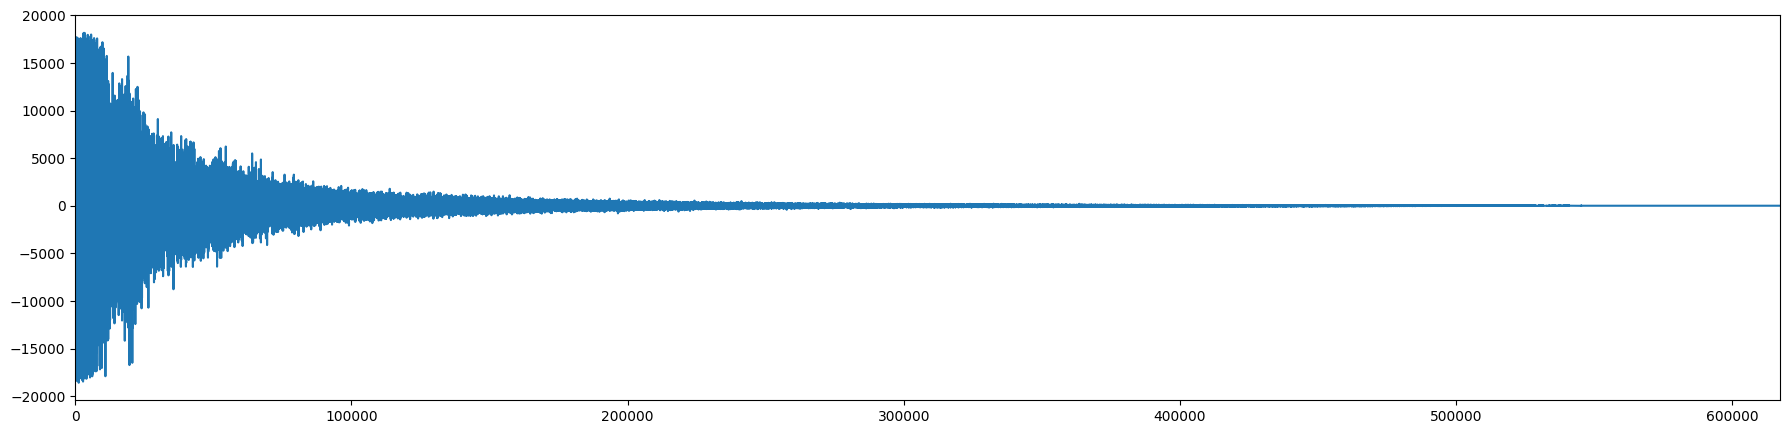

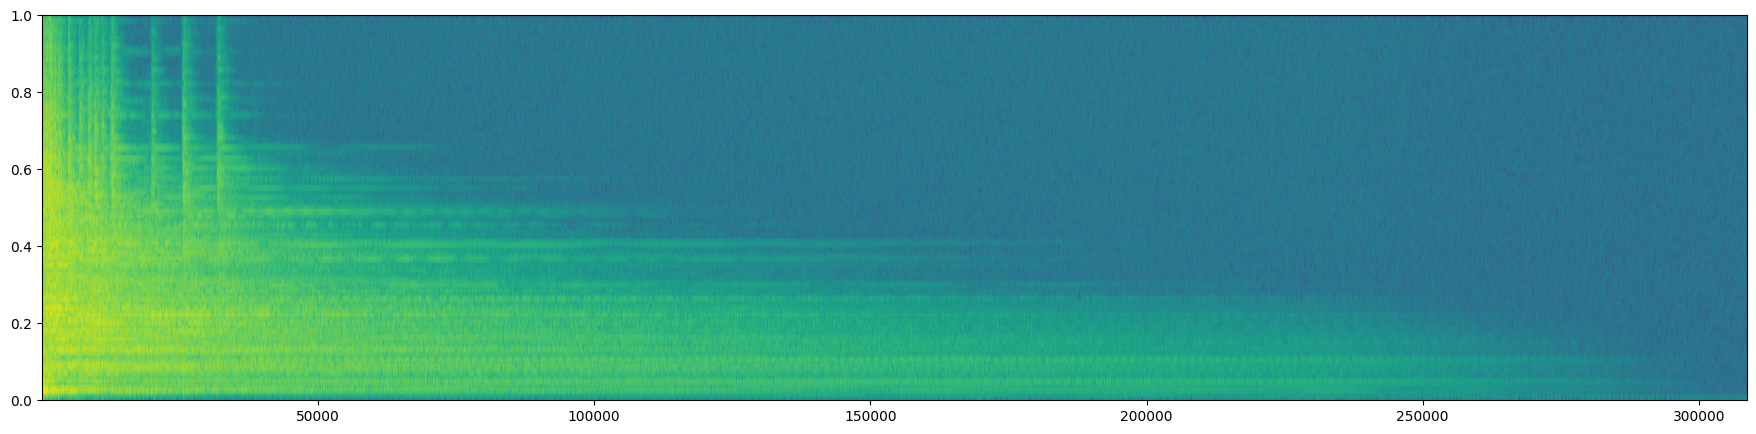

In [12]:
# Let's see (and hear?) the first value of audio_train (to make sure it's a waveform)
from hum import disp_wf, plot_wf

k, wf = next(iter(audio_train.items()))
plot_wf(wf)
disp_wf(wf)

In [13]:
# Let's make sure audio_train and the meta info are aligned

def assert_that_the_meta_and_audio_are_aligned(meta_names, audio_names):
    train_not_in_meta = set(audio_names) - set(meta_names)
    meta_not_in_train = set(meta_names) - set(audio_names)

    assert train_not_in_meta == meta_not_in_train == set(), (
        f"Meta and audio are not aligned!"
    )

assert_that_the_meta_and_audio_are_aligned(meta_train.fname, audio_train)
assert_that_the_meta_and_audio_are_aligned(meta_test.fname, audio_test)


In [15]:
train_tag_counts = pd.Series(Counter(meta_train['label'])).sort_values(ascending=False)
test_tag_counts = pd.Series(Counter(meta_test['label'])).sort_values(ascending=False)
train_tag_counts
# test_tag_counts

Hi-hat                   300
Laughter                 300
Shatter                  300
Applause                 300
Squeak                   300
Acoustic_guitar          300
Bass_drum                300
Saxophone                300
Flute                    300
Double_bass              300
Tearing                  300
Fart                     300
Clarinet                 300
Fireworks                300
Trumpet                  300
Violin_or_fiddle         300
Cello                    300
Snare_drum               300
Oboe                     299
Gong                     292
Knock                    279
Writing                  270
Cough                    243
Bark                     239
Tambourine               221
Burping_or_eructation    210
Cowbell                  191
Harmonica                165
Drawer_open_or_close     158
Meow                     155
Electric_piano           150
Gunshot_or_gunfire       147
Microwave_oven           146
Keys_jangling            139
Telephone     

## And finally: Our `dacc` (data access object)

In [20]:
from slang import KvDataSource, mk_chunker
from i2 import Sig
from functools import partial

dacc = KvDataSource(
    kv_store=audio_train, 
    key_to_tag=meta_train.set_index('fname').label.to_dict().get,
)

chunker = mk_chunker(2048)
chk, tag = next(dacc.chk_tag_pairs(chunker))


In [21]:
from slang import ClassificationSnipper

snipper = ClassificationSnipper(wf_to_chks={'chk_size': 2048}, 
                          chk_to_fv={'n_components': 2}, 
                          fv_to_snip={'n_clusters': 47})

(snipper
    .fit_chk_to_fv(dacc.chk_tag_pairs(snipper.wf_to_chks))  # fit on (chk, tag) pairs
    .fit_fv_to_snip(dacc.fv_tag_pairs(snipper.wf_to_chks, snipper.chk_to_fv))  # fit on (fv, tag) pairs
    .fit_snip_to_score(  # fit on (snip tag) pairs
        ((snipper.fv_to_snip(fv), tags) 
             for fv, tags in dacc.fv_tag_pairs(snipper.wf_to_chks, snipper.chk_to_fv)))
)


In [ ]:

# from omodel.fv.spectral_projector import MyLDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis().fit(X, y)

from sklearn.cluster import KMeans
XX = lda.transform(X)
kmeans = KMeans(n_clusters=160).fit(XX)

# Scrap from the past...

In [41]:
# from py2store import ZipReader, QuickBinaryStore

# source = ZipReader('/D/Dropbox/_odata/kaggle/freesound-audio-tagging.zip')
# target = QuickBinaryStore('/D/Dropbox/_odata/kaggle/')
# for k in s:
#     if k.endswith('.csv'):
#         print(k)
#         target[k] = source[k]

In [18]:
# from py2store import wrap_kvs
# import pandas as pd
# from io import BytesIO
# import soundfile as sf

# # def deserialize_wrt_suffix(k, v, assert_sr=44100):
# def deserialize_wrt_suffix(k, v):
#     assert_sr = 44100
#     if k.endswith('.csv'):
#         return pd.read_csv(BytesIO(v))
#     elif k.endswith('.wav'):
#         wf, sr = sf.read(BytesIO(v), dtype='int16')
#         assert sr == assert_sr, f"samplerate of {k} was not {assert_sr}"
#         return wf
#     else:
#         return v

In [19]:
# KaggleAudio = wrap_kvs(ZipReader, name='KaggleAudio', postget=deserialize_wrt_suffix)
# ka = KaggleAudio('/D/Dropbox/_odata/kaggle/freesound-audio-tagging.zip')

# k = list(ka)[0]; v = ka[k]
# print(f"{k}: {type(v)}, {v.shape}")
# k = list(ka)[-1]; v = ka[k]
# print(f"{k}: {type(v)}, {v.shape}")

audio_test/00063640.wav: <class 'numpy.ndarray'>, (69678,)
train_post_competition.csv: <class 'pandas.core.frame.DataFrame'>, (9473, 5)


In [39]:
# train_df = ka['train.csv']
# print(train_df.shape)
# train_df.head()

In [22]:
# from py2store.util import groupby, regroupby
# from ut.ml.test.controlled_splits import *

In [20]:
k = list(ka)[10000]

def fname_to_name(fname):
    return os.path.basename(os.path.splitext(k)[0])

def fname_to_pname(fname):
    return fname_to_name(fname) + '.p'

In [28]:
spectr_of_wf(ka[f'audio_train/{fname}'])

array([[7.23148293e+03, 1.70482536e+04, 3.10952731e+04, ...,
        1.65788000e+04, 2.30449411e+04, 2.00084818e+04],
       [8.69721873e+03, 1.90342522e+04, 3.33423987e+04, ...,
        3.88668040e+04, 3.52090931e+04, 2.90490804e+04],
       [1.56615726e+04, 1.25398440e+04, 6.09951236e+03, ...,
        3.19108294e+03, 7.54234418e+03, 1.05871564e+04],
       ...,
       [5.09169018e+02, 2.68971751e+02, 4.58661961e+01, ...,
        4.84128044e+01, 4.66837335e+01, 4.63045068e+01],
       [5.16448026e+02, 2.61949830e+02, 1.44661361e+01, ...,
        3.66249751e+01, 3.04010594e+01, 8.32504359e+00],
       [5.24226891e+02, 2.52362122e+02, 2.18915932e+01, ...,
        2.86944200e+01, 3.27047381e+01, 1.58595508e+01]])

In [31]:
spectr_of_wf(ka[f'audio_train/{fname}'])

array([[7.23148293e+03, 1.70482536e+04, 3.10952731e+04, ...,
        1.65788000e+04, 2.30449411e+04, 2.00084818e+04],
       [8.69721873e+03, 1.90342522e+04, 3.33423987e+04, ...,
        3.88668040e+04, 3.52090931e+04, 2.90490804e+04],
       [1.56615726e+04, 1.25398440e+04, 6.09951236e+03, ...,
        3.19108294e+03, 7.54234418e+03, 1.05871564e+04],
       ...,
       [5.09169018e+02, 2.68971751e+02, 4.58661961e+01, ...,
        4.84128044e+01, 4.66837335e+01, 4.63045068e+01],
       [5.16448026e+02, 2.61949830e+02, 1.44661361e+01, ...,
        3.66249751e+01, 3.04010594e+01, 8.32504359e+00],
       [5.24226891e+02, 2.52362122e+02, 2.18915932e+01, ...,
        2.86944200e+01, 3.27047381e+01, 1.58595508e+01]])

In [32]:
s = QuickPickleStore('/D/Dropbox/_odata/kaggle/tag_spectr')
s[f'{tag}/{fname_to_pname(fname)}'] = spectr_of_wf(ka[f'audio_train/{fname}'])

In [37]:
from ut.util.log import print_progress

from omodel.core.spectro import get_wf_to_spectr_func
_spectr_of_wf = get_wf_to_spectr_func()
spectr_of_wf = lambda wf: _spectr_of_wf(wf).T

def fname_to_name(fname):
    return os.path.basename(os.path.splitext(fname)[0])

def fname_to_pname(fname):
    return fname_to_name(fname) + '.p'

# TagSpectrums = wrap_kvs(QuickPickleStore, name='TagSpectrums', data_of_obj=spectr_of_wf)
ts = QuickPickleStore('/D/Dropbox/_odata/kaggle/tag_spectr')

print(f"Starting to process all {len(train_df)} items...")
for i, (fname, tag) in enumerate(zip(train_df.fname, train_df.label), 1):
    if i % 1000 == 0:
        print_progress(i)
    ts[f'{tag}/{fname_to_pname(fname)}'] = spectr_of_wf(ka[f'audio_train/{fname}'])

Starting to process all 9473 items...
(21)16:33:04 - 1000 
(21)16:33:19 - 2000 
(21)16:33:34 - 3000 
(21)16:33:49 - 4000 
(21)16:34:04 - 5000 
(21)16:34:18 - 6000 
(21)16:34:33 - 7000 
(21)16:34:47 - 8000 
(21)16:35:03 - 9000 


In [79]:
from py2store.stores.local_store import DirStore

TagSpectrums = wrap_kvs(DirStore, name='TagSpectrums', obj_of_data=lambda x: QuickPickleStore(x._prefix))

ts = TagSpectrums('/D/Dropbox/_odata/kaggle/tag_spectr')
tag, spectrums = ts.head()
print(tag)
type(spectrums), spectrums.head()

Snare_drum


(py2store.stores.local_store.QuickPickleStore,
 ('53dda34d.p', array([[2.49375045e+04, 1.77585269e+04, 9.34129542e+03, ...,
          7.46147967e+01, 7.17025687e+01, 1.72060740e+01],
         [5.41957791e+04, 2.34293250e+04, 8.93969502e+03, ...,
          2.86200651e+01, 5.65597805e+01, 5.29704746e+01],
         [4.51956340e+04, 2.13909895e+04, 3.11050541e+04, ...,
          1.12966903e+02, 1.57112948e+02, 1.53940536e+02],
         ...,
         [8.82987871e+04, 4.32865189e+04, 2.38802963e+03, ...,
          3.96914015e+01, 2.35085909e+01, 1.24180918e+00],
         [6.20336630e+04, 3.12207813e+04, 5.21309707e+02, ...,
          2.53300880e+01, 1.10183764e+01, 2.98402526e+01],
         [3.08447613e+04, 1.62812714e+04, 3.90743126e+02, ...,
          3.66764627e+01, 6.12947543e+01, 6.37038860e+01]])))

In [91]:
import itertools

def tag_spectrum_gen(tag_spectrums, max_n_files_per_tag=4):
    for tag, spectrums in ts.items():
        for spectr in np.vstack(list(itertools.islice(spectrums.values(), 0, max_n_files_per_tag))):
            yield tag, spectr

y, X = list(map(np.array, zip(*tag_spectrum_gen(ts))))

In [147]:
# QuickPickleStore(os.path.abspath('.'))['tmp.p'] = (X, y)


In [107]:
# from omodel.fv.spectral_projector import MyLDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis().fit(X, y)

In [109]:
# QuickPickleStore(os.path.abspath('.'))['kaggle_audio_spectr_lda_1.p'] = lda

In [143]:
from sklearn.cluster import KMeans
XX = lda.transform(X)
kmeans = KMeans(n_clusters=160).fit(XX)

In [148]:
# QuickPickleStore(os.path.abspath('.'))['kaggle_kmeans.p'] = kmeans

In [151]:
from collections import Counter, defaultdict

c = Counter(zip(y, kmeans.predict(XX)))

Counter({('Snare_drum', 73): 3,
         ('Snare_drum', 110): 3,
         ('Snare_drum', 49): 4,
         ('Snare_drum', 85): 1,
         ('Snare_drum', 1): 76,
         ('Snare_drum', 13): 7,
         ('Snare_drum', 54): 1,
         ('Snare_drum', 96): 1,
         ('Snare_drum', 66): 1,
         ('Snare_drum', 83): 1,
         ('Snare_drum', 140): 1,
         ('Bark', 1): 91,
         ('Bark', 73): 6,
         ('Bark', 71): 7,
         ('Bark', 88): 2,
         ('Bark', 46): 1,
         ('Bark', 148): 63,
         ('Bark', 138): 22,
         ('Bark', 23): 19,
         ('Bark', 127): 7,
         ('Bark', 142): 2,
         ('Bark', 47): 3,
         ('Bark', 129): 25,
         ('Bark', 125): 14,
         ('Bark', 146): 3,
         ('Bark', 32): 24,
         ('Bark', 76): 3,
         ('Bark', 149): 5,
         ('Bark', 78): 2,
         ('Bark', 61): 20,
         ('Bark', 109): 7,
         ('Bark', 57): 2,
         ('Bark', 147): 1,
         ('Bark', 66): 4,
         ('Bark', 19): 1,
     

In [217]:
snips_of_tag = defaultdict(list)
for tag, snips in zip(y, kmeans.predict(XX)):
    snips_of_tag[tag].append(snips)

In [173]:
from collections import defaultdict, Counter

from slang.utils.snip_stats import \
    tag_slice_iter_from_slices_of_tag_dict, \
    snip_count_for_tag_from_wf_and_tag_slice_iter,\
    df_of_snip_count_for_tag,\
    plot_snip_count_for_tag, \
    bar_plot_of_tag_snip_stats, \
    snip_order_from_snip_count_df,\
    bayes_factor_df_from_snip_count_df

from slang.utils.snip_stats import df_of_snip_count_for_tag, snip_count_for_tag_from_wf_and_tag_slice_iter
from slang.util import str_of_snips


In [180]:
snip_count_for_tag = defaultdict(dict)

for (tag, snip), count in Counter(zip(y, kmeans.predict(XX))).items():
    snip_count_for_tag[tag][snip] = count

snip_count_for_tag = dict(snip_count_for_tag)
# snip_count_for_tag = {tag: snip for (tag, snips in Counter(zip(y, kmeans.predict(XX))).items()}
print(str(snip_count_for_tag)[:150])

{'Snare_drum': {73: 3, 110: 3, 49: 4, 85: 1, 1: 76, 13: 7, 54: 1, 96: 1, 66: 1, 83: 1, 140: 1}, 'Bark': {1: 91, 73: 6, 71: 7, 88: 2, 46: 1, 148: 63, 1


In [174]:
string_of_snips = str_of_snips

df = df_of_snip_count_for_tag(snip_count_for_tag, fillna=0)
snip_order = snip_order_from_snip_count_df(df)
print(string_of_snips(snip_order))

tag_order = list(snip_count_for_tag.keys())

bË1ÄĎðStåÚêēÔDěÕsÆ×ÇeßöpræWÀĘdïÉùC3āÁuõđØyâĖĂcė4AęĄzÎRoÜġEjĜKäìÌĊĉüčèĆéÂúiĈÙÓálLçĠÛċþÏgĝûÍÊfqýàñYÃMwÞëãIVÒćíPóXĔ6ăòNvČxTą8È2ZÿH7ÅîOkømÖU0ÑBĕĀĢ÷aÐn5ĚJh9ÝĒĞQďôGFğ


In [183]:
log_bayes_factor = np.log2(bayes_factor_df_from_snip_count_df(df))
log_bayes_factor

Snare_drum      Bark     Chime    Hi-hat     Cello  Applause  \
snip                                                                 
73     -1.671511 -1.886871  0.107300 -4.061660 -2.909940  1.003789   
110     0.433708 -2.603001 -0.360550 -0.961369 -3.626070  2.076909   
49      3.442849  0.000919  0.686756  0.638779 -1.022150  2.509576   
85      0.139378 -1.892166 -2.270540 -0.248127 -2.915234 -3.388803   
1      -0.526095 -1.293162 -0.251348 -0.331038 -1.380132 -1.862071   
...          ...       ...       ...       ...       ...       ...   
28      1.096673  0.071309 -1.313244  0.709169 -0.951760 -1.425329   
34      1.072827  0.047462 -1.337091  0.685322 -0.975607 -1.449176   
143     1.511711  0.486346 -0.898207  1.124206 -0.536723 -1.010291   
26      1.248677  0.223312 -1.161241  0.861172 -0.799757 -1.273326   
155     1.511711  0.486346 -0.898207  1.124206 -0.536723 -1.010291   

      Computer_keyboard  Clarinet  Gunshot_or_gunfire     Cough  ...  \
snip                                                             ...   
73            -3.262249 -0.809974            0.784709 -0.234946  ...   
110           -1.468995 -3.052216           -1.316087  1.095305  ...   
49            -1.891686 -0.448295            1.307146  0.201625  ...   
85            -2.778592  1.654516           -1.609022 -0.094113  ...   
1              0.937389 -1.184751           -0.874456 -0.440805  ...   
...                 ...       ...                 ...       ...  ...   
28            -1.821297 -0.377906            0.354452  0.272014  ...   
34            -1.845143 -0.401752            0.330605  0.248168  ...   
143           -1.406259  0.037132            0.769489  0.687052  ...   
26            -1.669294 -0.225902            0.506455  0.424018  ...   
155           -1.406259  0.037132            0.769489  0.687052  ...   

      Drawer_open_or_close  Microwave_oven     Flute   Shatter      Gong  \
snip                                                                       
73               -0.554480        0.696781  2.655605 -2.103712 -2.289936   
110              -1.467462       -2.633646 -4.197389 -0.310458 -2.784329   
49                1.155771       -0.010414 -1.593468 -0.733150 -1.184180   
85               -1.760398       -2.926582 -0.870430 -1.620056 -3.077265   
1                 0.474011       -0.538513 -0.454988  0.386671  0.178443   
...                    ...             ...       ...       ...       ...   
28                0.203077       -0.963108 -1.523079  4.314520 -1.113791   
34                0.179230       -0.986955 -1.546926 -0.686607 -1.137637   
143               0.618114       -0.548071 -1.108042 -0.247723 -0.698753   
26                0.355080       -0.811105 -1.371076 -0.510757 -0.961788   
155               0.618114       -0.548071 -1.108042 -0.247723 -0.698753   

         Knock  Burping_or_eructation  Double_bass  Electric_piano   Writing  
snip                                                                          
73    0.544226              -0.386052    -2.614695       -2.925093 -1.759251  
110  -2.767574               4.549557    -2.104901       -1.827447  1.509549  
49   -1.167425               0.301115     0.499020       -0.227298 -1.322680  
85   -3.060509              -1.591970    -1.394065       -2.120383 -3.215765  
1     0.857483              -0.992967    -1.464090        0.478480 -0.221748  
...        ...                    ...          ...             ...       ...  
28   -1.097035               0.371504     0.569409       -0.156909 -1.252291  
34   -1.120882               0.347658     5.613803       -0.180755 -1.276138  
143  -0.681998               0.786542     0.984447        3.013016 -0.837253  
26   -0.945032               0.523507     0.721412        4.334944 -1.100288  
155  -0.681998               0.786542     0.984447        3.013016 -0.837253  

[160 rows x 41 columns]

In [177]:
def scores_of_snips(tag, snips, log_bayes_factor):
    return list(map(log_bayes_factor[tag].loc.__getitem__, snips))

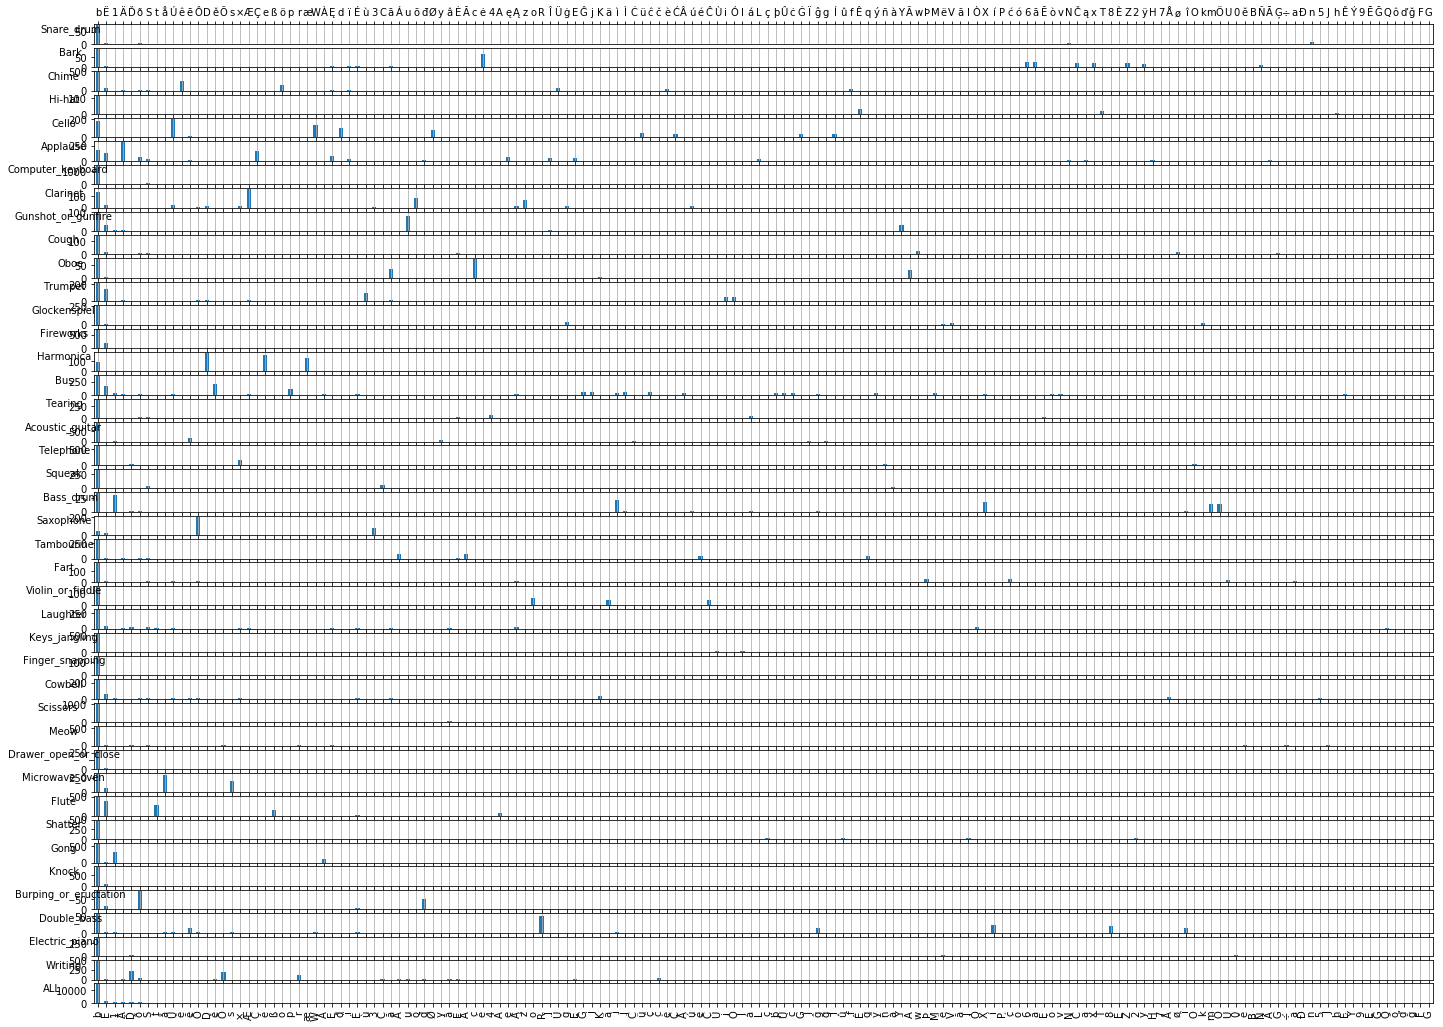

In [259]:
plot_snip_count_for_tag(snip_count_for_tag, string_of_snips=str_of_snips, figsize=(24, 18), ylabel_rotation=0)

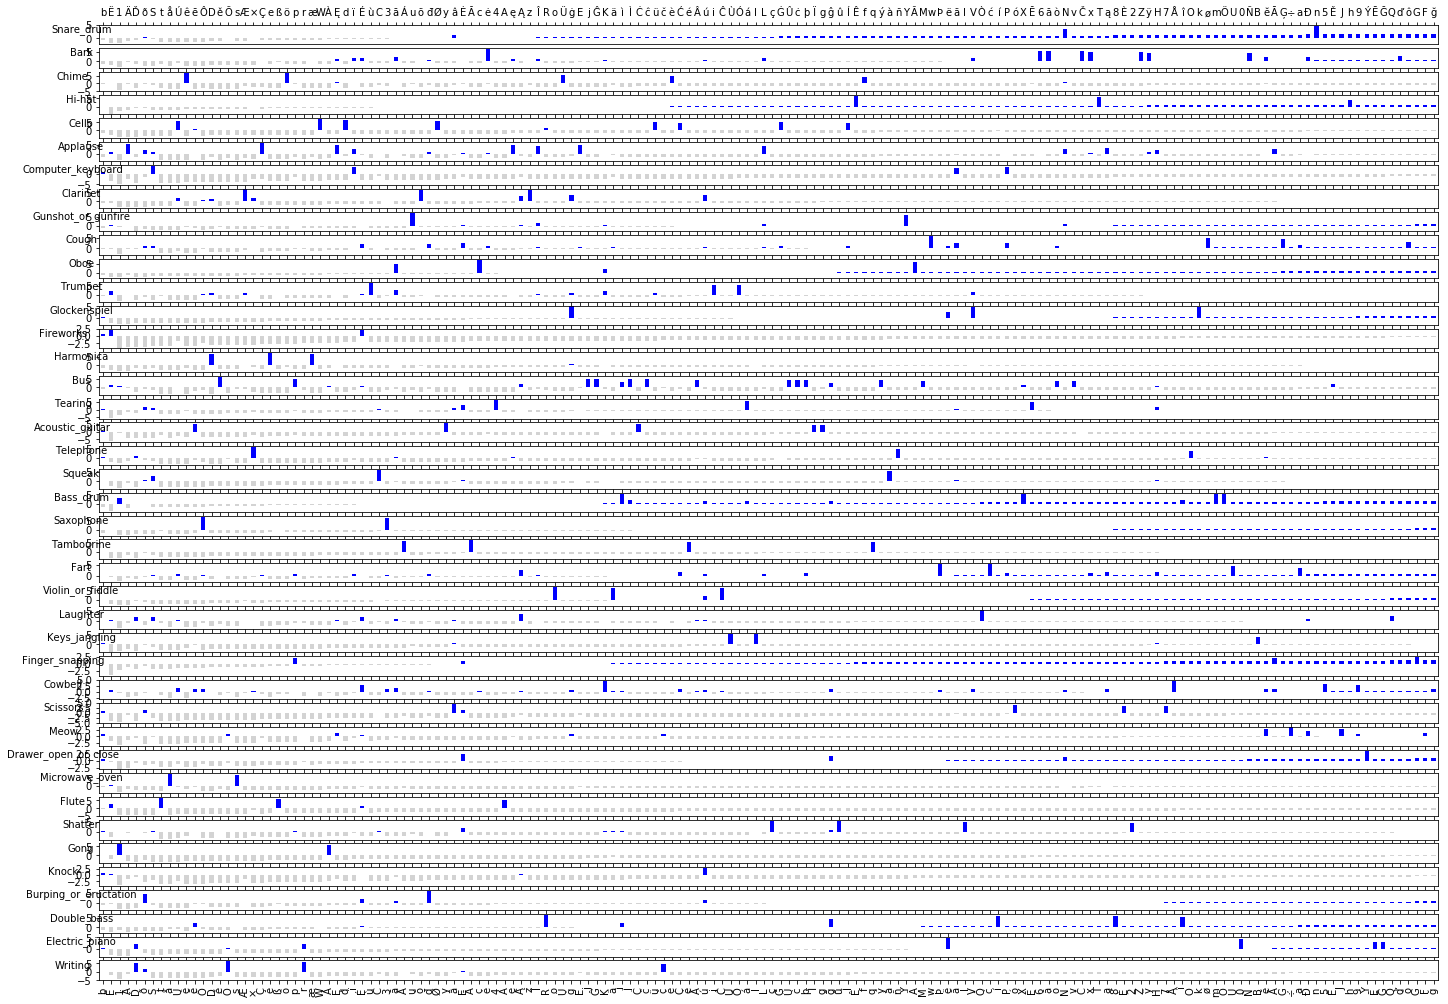

In [256]:
log_bayes_factor = np.log2(bayes_factor_df_from_snip_count_df(df))

bar_plot_of_tag_snip_stats(log_bayes_factor, string_of_snips=str_of_snips, figsize=(24, 18), 
                           snip_order=snip_order, ylabel_rotation=0) #tag_order=tag_order)

In [209]:
snip_order

array([  1,  73,  27,  66, 140, 110,  54,  19,  99,  88, 104, 144,  82,
        39, 152,  83,  18,  68,  85,  69,   4,  93, 116,  15,  17, 100,
        58,  62, 149,   3, 109,  71, 119,  38,  29, 127,  63,  20, 115,
       142,  86,  24,  96, 147, 128,   2, 148,  30,  36, 150, 130,  25,
        76,  53,  14,  90, 158,  40,   9, 153,  46,  98, 106,  74, 136,
       135, 122, 139, 102, 132, 103,  64, 120,   8, 134,  87,  81,  95,
        11,  47, 101, 157,  89, 137, 124,  77,   6, 154, 121,  75,  72,
         5,  16, 123,  94, 111,  60,  65,  48,  22,  92, 105,  97,  44,
        57,  80, 133, 107,  51, 113,  59, 145,  32, 129, 112,  49,  21,
       138,  23,  55, 131,  34,  70,  28,  61, 125,  43,  33,  67, 108,
        50,  10, 118,  12,  84,  56,  26,  79,  37, 146, 126, 159, 117,
         0,  78,  13,  31, 151,  45,   7,  35,  91, 143, 155,  52, 141,
       114,  42,  41, 156])

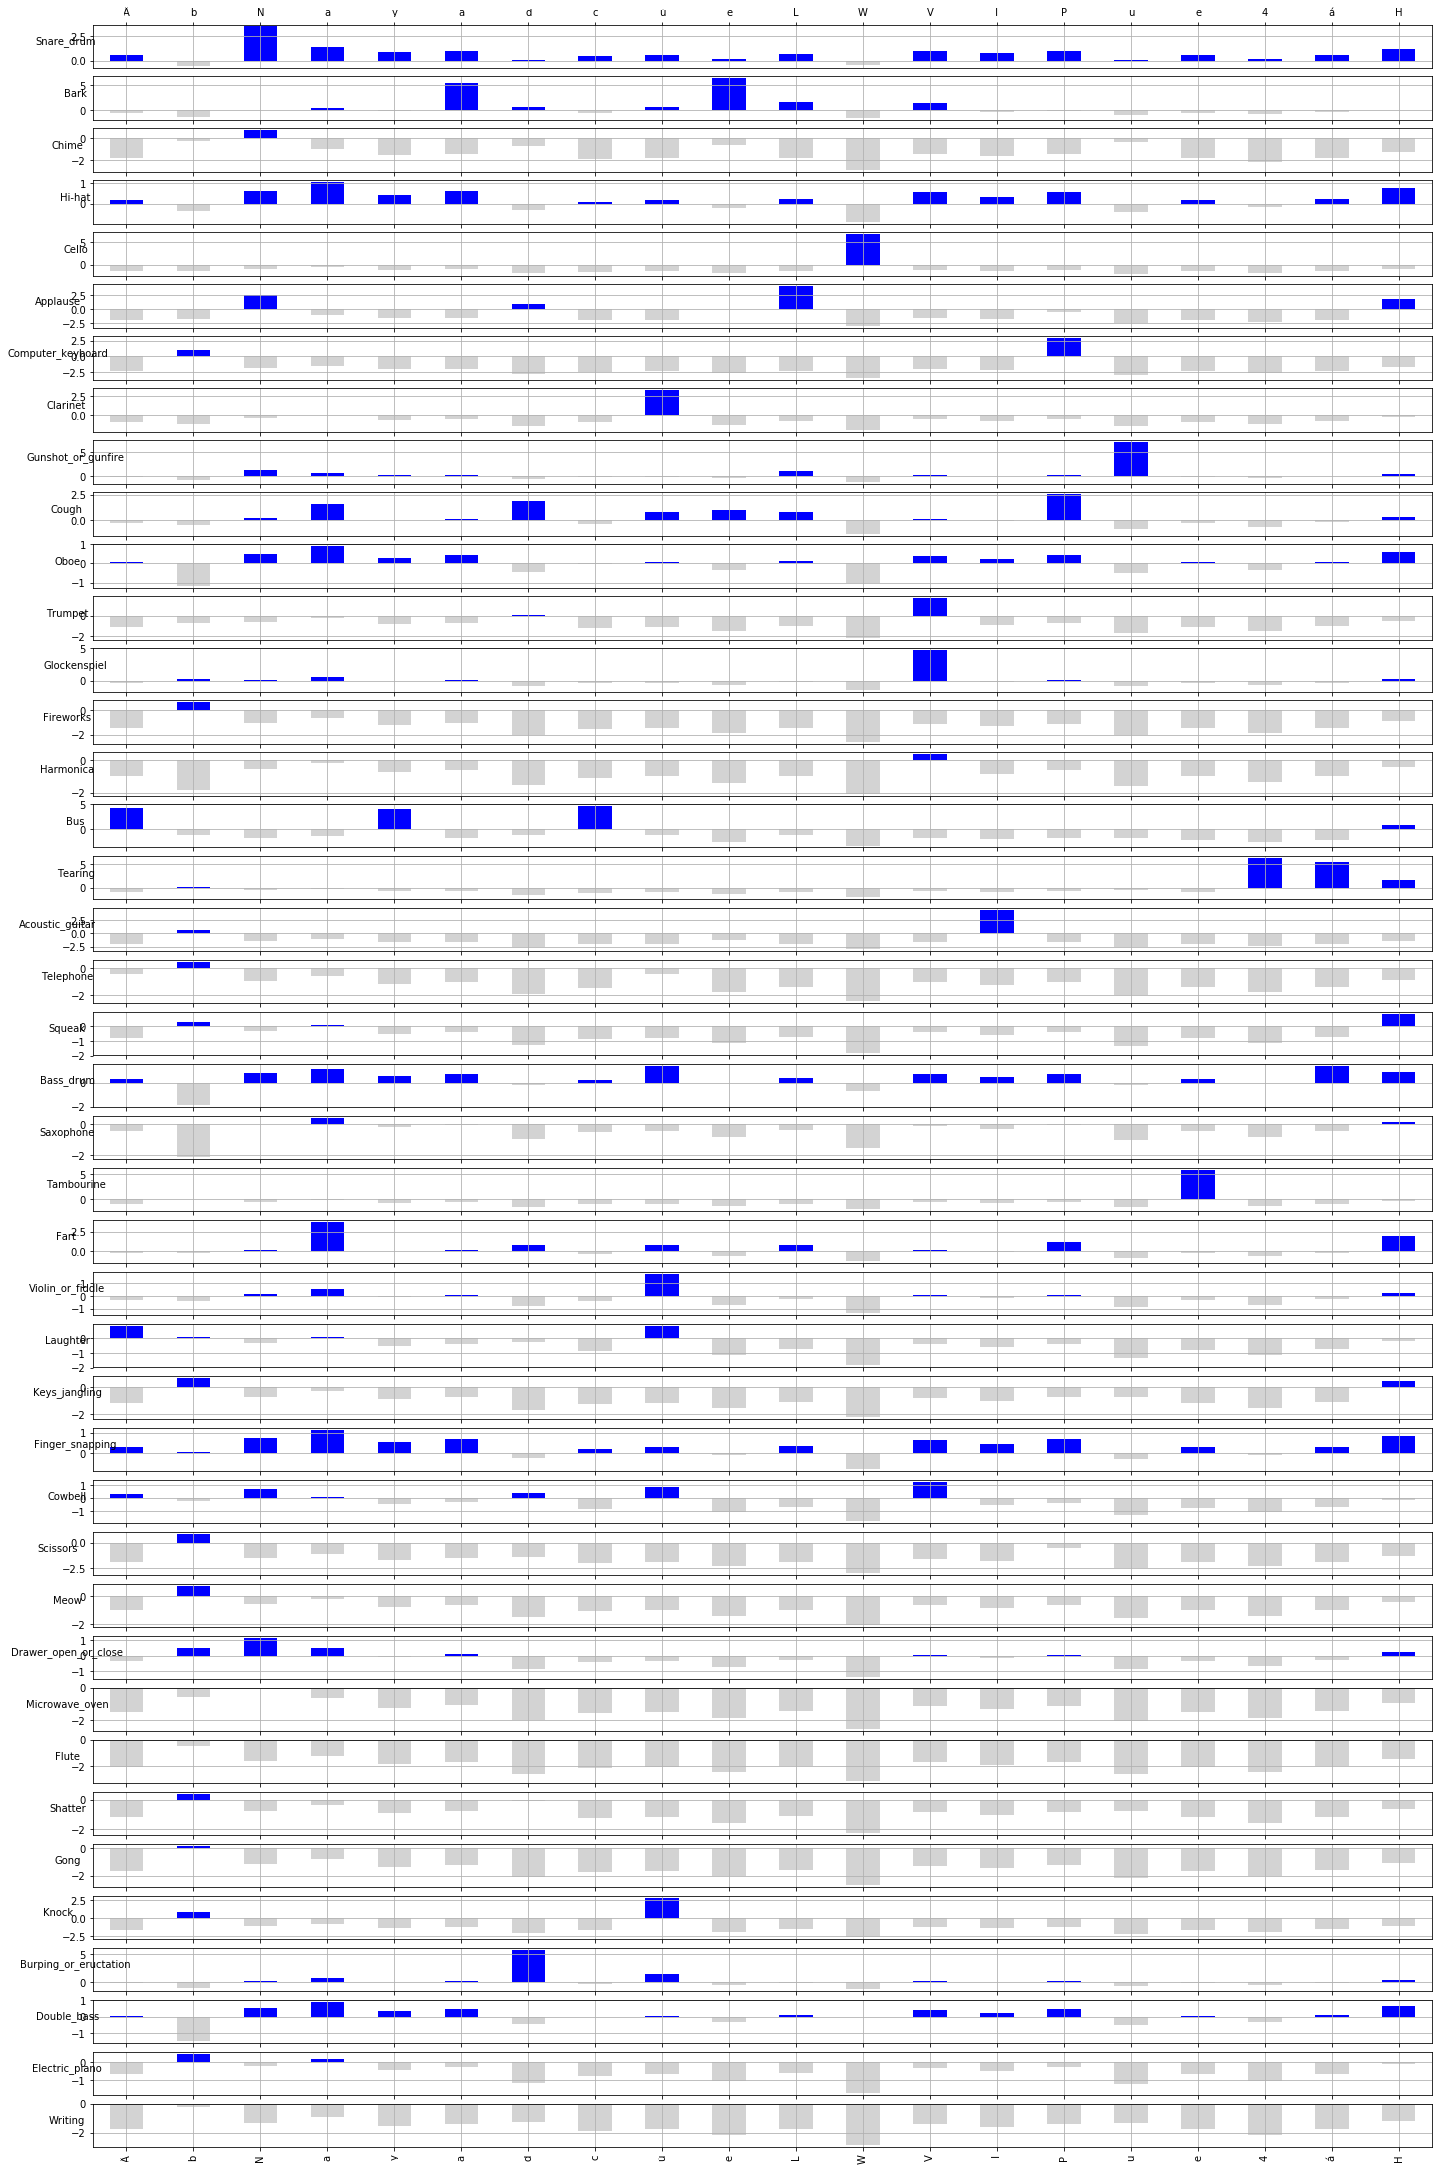

In [225]:
# A subset of the previous, where we keep only the n (here 20) top (log_bayes_factor) snips.

log_bayes_factor = np.log2(bayes_factor_df_from_snip_count_df(df))
snips_in_order_of_importance = \
    log_bayes_factor.index.values[np.argsort(-log_bayes_factor.max(axis=1).values)]
t = log_bayes_factor.iloc[snips_in_order_of_importance].iloc[:20]
bar_plot_of_tag_snip_stats(t, string_of_snips=str_of_snips, 
                           figsize=(24, 40), ylabel_rotation=0) #tag_order=tag_order)

In [226]:
# snips_of_tag = defaultdict(list)
# for snips, tag in snips_tag_gen(block_store, annots, snipper):
#     snips_of_tag[tag].extend(list(snips))
    
snips_of_tag = defaultdict(list)
for tag, snips in zip(y, kmeans.predict(XX)):
    snips_of_tag[tag].append(snips)
snips_of_tag = dict(snips_of_tag)
print(str(snips_of_tag)[:200])

{'Snare_drum': [73, 110, 49, 49, 85, 110, 73, 73, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 13, 13, 13, 13, 13, 54, 49, 96, 110, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,


In [221]:
for tag, snips in snips_of_tag.items():
    print("{:<21}: {}\n".format(tag, string_of_snips(snips)))

Snare_drum           : ËðNN×ðËËbbbbbbbbbbbbnnnnnSNâðbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbÄnnNÕĎbbbbbbbbbbbbbbbbbbbbbb

Bark                 : bËÉÉÉÉËÚËKėČČėČxėėČāėđāLăāăxLăÿăÿăėăėĕ6ÎĘăÐÿÿėĘ6ÿāxÿă66Ę66666xZxZČïïėÿėÎxăÿăVėėČėėėĖėėėÄėėïėÄėėÄtßāxČėxÇxÑõæzxČČxxČČė6ZÑZėėė6ČÑÑČę6æïï6ÿÐăăÑăăZėĕ6x6ÿĕÉđėxă6ăVÿÿÎZāėZė6ČxČėČ66ZăėxČęZZZZ6ėėăxėČČZZZ666ėėxZLăăėăėėėÇÿÑăÑÑÿ6ėėČïėėČČxėėėėïėėėėÇėĘėĘėėėbbbbbbbbbbbbbbúďÑėėËbbbbbbbbbbbbbbbbbÚďďăėÉbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbËÑZÑÉbbbbbbbĎbbbbbÄęăZZābbbbbăÑÑZËbbbbb

Chime                : ÜèÜèèèbêêèÜèfèööêbÜêbêêêêêêèöêêêbbèöêbbêêêêöêbbbbbbbbbbbbbbbbbbbbbbbbbbbêêêêöCèÜÜÜööÜÜööêööêđèffÜfÜÜfÜÜÜöööööööêÜ3fÜööÜÜÜöÜööêöêêêêêêêêêêööööööêêêêêêêêêêêêêêêêêêËbËêbêèöèööööêêöêêêêêêêêêêêöêêêêêêêêêêêöêêêêêêêêêêêbêêbêbËËËËöÜbËbêĘbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbËËËËËbbbSïbbbbËāËbbbÄËbbbbbbbbbbNbbËbbzËbbËbĘËbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbÔËbÆĘËbbāêËbËbbbbbbbbbËËbbbËbbbbËbbbbÄbËËbËbbbËbbbbbbbbāêðbïNËËbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbbÄbêėÄÄðĘĘbb

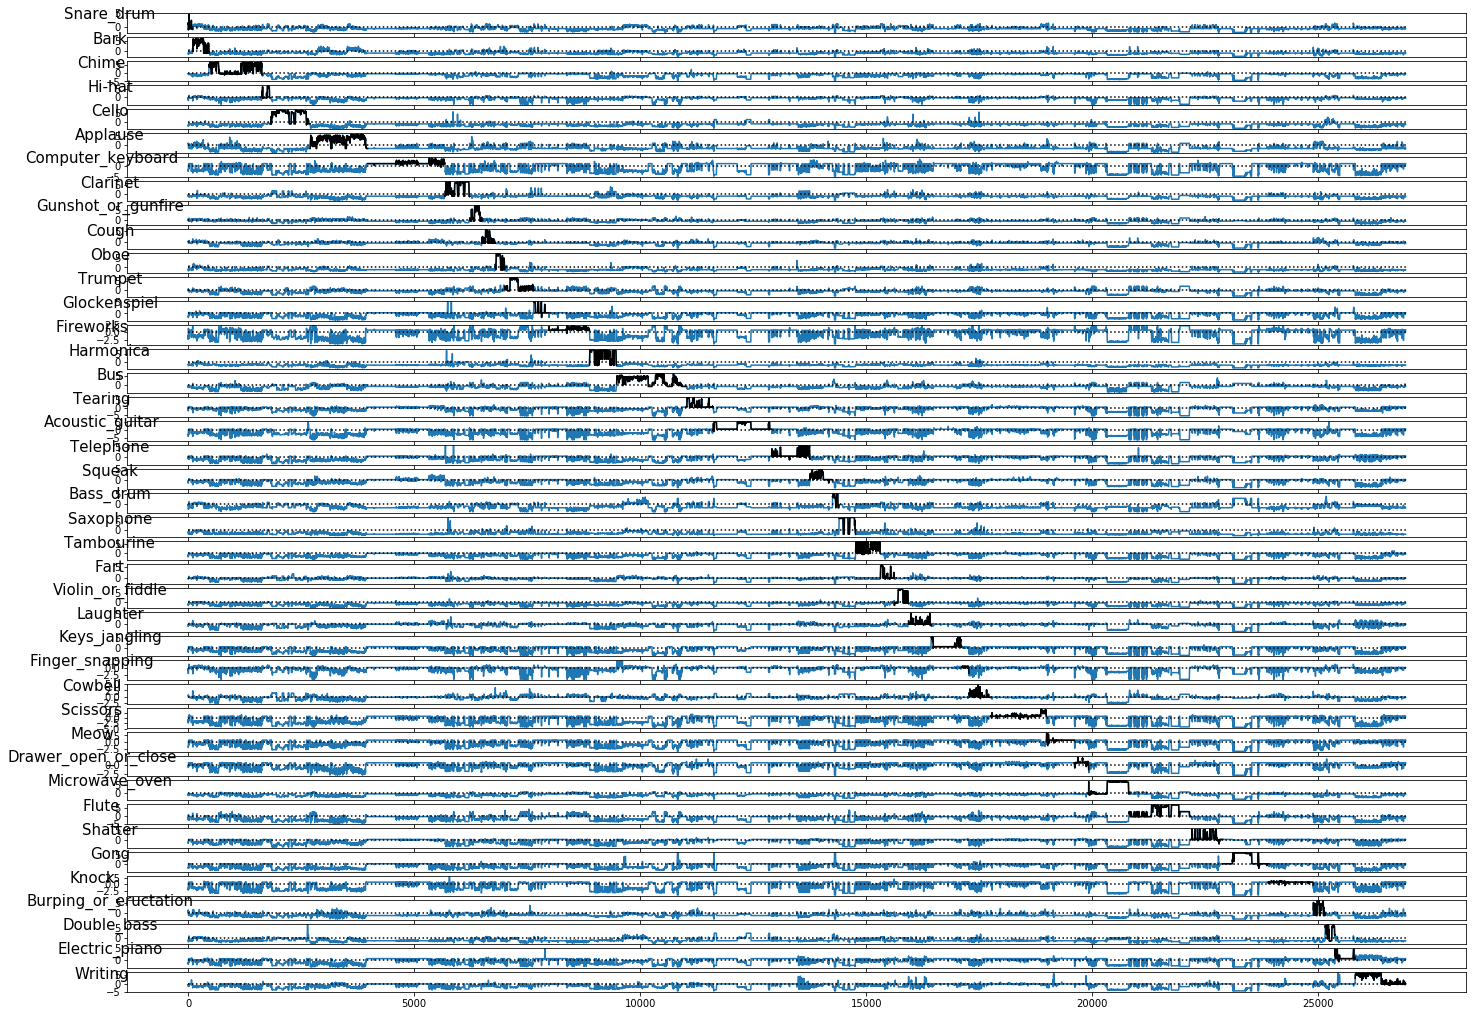

In [254]:
from ut.util.uiter import running_mean
from functools import reduce

chk_size_tile = 5

n_tags = len(tag_order)

all_snips = reduce(lambda x, y: x + y, snips_of_tag.values(), [])

plt.figure(figsize=(24, 18)); 

tag_snips_cursor = 0
for i, tag in enumerate(tag_order, 1):
    plt.subplot(n_tags, 1, i);
    snip_scores = list(running_mean(scores_of_snips(tag, all_snips, log_bayes_factor), chk_size_tile))
    plt.plot(snip_scores, '-');
    plt.plot([0, len(snip_scores)], [0, 0], ':k')
    
    n_tag_snips = len(snips_of_tag[tag])
    these_snip_scores = snip_scores[tag_snips_cursor:(tag_snips_cursor + n_tag_snips)]
    tag_snips_idx = list(range(tag_snips_cursor, tag_snips_cursor + len(these_snip_scores)))
    plt.plot(tag_snips_idx, these_snip_scores, 'k-');
    tag_snips_cursor += n_tag_snips

    plt.axis('tight')
    plt.ylabel(tag, fontsize=15, rotation=0);
    
#     if i > 4:
#         break

In [ ]:
from slang.utils.snip_stats import plot_tag_scores_for_snips

plot_tag_scores_for_snips(snips_of_tag, snip_tag_score_df=log_bayes_factor, smoothing_window_size=7)

# Scrap: CentroidSmoothing

In [112]:
from omodel.ml.scent import CentroidSmoothing

m = CentroidSmoothing().fit(X, y)
sum(m.predict(X) == y) / len(y)

0.13143727026324584

In [113]:
1 / len(np.unique(y))

0.024390243902439025

In [123]:
tag, spectrums = next(itertools.islice(ts.items(), 0, 1))
x = next(itertools.islice(spectrums.values(), 0, 1))
tag, x.shape

('Snare_drum', (20, 1025))

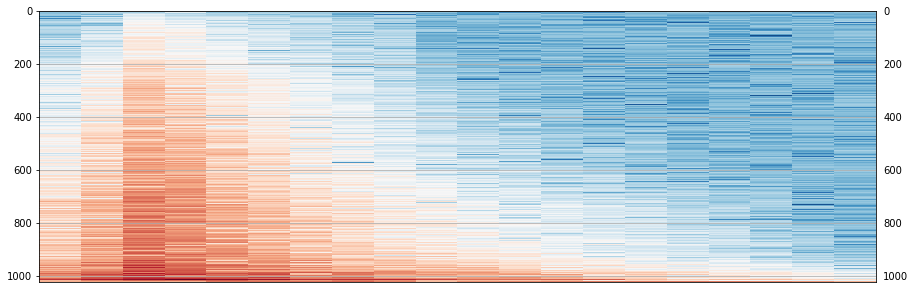

In [130]:
from ut.pplot.matrix import heatmap

heatmap(np.log(x).T[::-1], figsize=(15, 5))

In [ ]:
plt.plot(m.predict_proba(X[:100]))

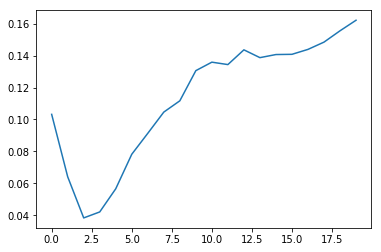

In [139]:
plt.plot(np.ravel(m.predict_proba(x)[:, m.classes_ == tag]))

In [ ]:
def wf_tag_gen(df, name_to_wf, name_field='fname', tag_field='label'):
    for name, tag in zip(train_df.fname, train_df.label):
        yield name_to_wf(name), tag
    
def spectr_tag_gen(wf_tags, spectr_of_wf=spectr_of_wf):
    for wf, tag in wf_tags:
        for x in spectr_of_wf(wf):
            yield list(x), tag
            
wf_tags = wf_tag_gen(train_df, lambda name: ka[f'audio_train/{name}'])
spectr_tags = spectr_tag_gen(wf_tags)

In [ ]:
# X, y = list(map(np.array, zip(*itertools.islice(spectr_tags, 0, 5))))

X, y = list(map(np.array, zip(*spectr_tags)))

In [ ]:
TagSpectrums = QuickPickleStore('/D/Dropbox/_odata/kaggle/tag_spectr')

In [564]:
from omodel.fv.spectral_projector import SpectralProjectorSupervisedFitter

t = spectr_of_wf(wf)
len(list(iter(t)))

301

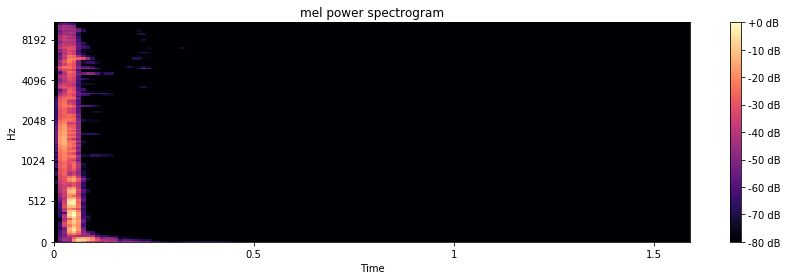

In [541]:
from ocore.audio.audio import Sound

Sound(wf).display()

In [511]:
from collections import Counter

k = 'train.csv'
print(k)
v = s[k]
df = pd.read_csv(BytesIO(v))
print(df.shape)
print(df.head())
print(df.tail())
Counter(df['label'])

train.csv
(9473, 3)
          fname         label  manually_verified
0  00044347.wav        Hi-hat                  0
1  001ca53d.wav     Saxophone                  1
2  002d256b.wav       Trumpet                  0
3  0033e230.wav  Glockenspiel                  1
4  00353774.wav         Cello                  1
             fname      label  manually_verified
9468  ffec59fb.wav  Fireworks                  0
9469  fff37590.wav     Hi-hat                  0
9470  fff44ac6.wav   Laughter                  0
9471  fff6a13d.wav      Chime                  0
9472  fff81f55.wav      Cough                  1


Counter({'Hi-hat': 300,
         'Saxophone': 300,
         'Trumpet': 300,
         'Glockenspiel': 94,
         'Cello': 300,
         'Knock': 279,
         'Gunshot_or_gunfire': 147,
         'Clarinet': 300,
         'Computer_keyboard': 119,
         'Keys_jangling': 139,
         'Snare_drum': 300,
         'Writing': 270,
         'Laughter': 300,
         'Tearing': 300,
         'Fart': 300,
         'Oboe': 299,
         'Flute': 300,
         'Cough': 243,
         'Telephone': 120,
         'Bark': 239,
         'Chime': 115,
         'Bass_drum': 300,
         'Bus': 109,
         'Squeak': 300,
         'Scissors': 95,
         'Harmonica': 165,
         'Gong': 292,
         'Microwave_oven': 146,
         'Burping_or_eructation': 210,
         'Double_bass': 300,
         'Shatter': 300,
         'Fireworks': 300,
         'Tambourine': 221,
         'Cowbell': 191,
         'Electric_piano': 150,
         'Meow': 155,
         'Drawer_open_or_close': 158,
         'Ap

In [487]:
s.info_for_key[t[-4]]

<ZipInfo filename='sample_submission.csv' compress_type=deflate file_size=329012 compress_size=49377>

In [304]:
class Param(Parameter):
    pass

Param(bar_params['d'])

TypeError: __init__() missing 1 required positional argument: 'kind'

In [385]:
from py2misc.py2store.exploration.attr_dict import special_dir, attr_wrap

A = attr_wrap(dict)
t = A({'a_special_attr': 'foo', 'another_attr': 2, # valid identifiers
       42: [1, 2], '$invalid': 'identifier', 'class': 'is a reserved keyword'})  # not valid identifiers
# verify that we have the attr we want
assert 'a_special_attr' in dir(t)
assert 'another_attr' in dir(t)
# verify that we DO NOT have the attr we DO NOT want
assert 42 not in dir(t)
assert '$invalid' not in dir(t)
assert 'class' not in dir(t)

from py2misc.py2store.exploration.attr_dict import AttrMap
t = AttrMap({'a': {'b': 2, 'foo': 'bar'}, 'b': [1,2,3]})
t
t.a
t.a.foo
t.b

[1, 2, 3]

In [103]:
p = Params(bar)
t = {k: p[k] for k in list(p)[::-1]}
Signature(dict(p).values())
Signature(dict(t).values())

ValueError: non-default argument follows default argument

In [37]:
def foo(a: int, b = 0) -> float: 
    return a + b

foo.__defaults__
foo.__annotations__
foo.__defaults__ = (0,1)

import inspect
inspect.signature(foo)

<Signature (a: int = 0, b=1) -> float>

In [47]:
sig = inspect.signature(foo)
sig = sig.replace(return_annotation=str)
foo.__signature__ = sig
print(foo.__defaults__, foo.__annotations__, foo.__defaults__)
# inspect.signature(foo)

(0, 1) {'a': <class 'int'>, 'return': <class 'float'>} (0, 1)


<Signature (a: int = 0, b=1) -> str>

In [58]:
params = list(sig.parameters.values())
params[0] = params[0].replace(default=10)
params

[<Parameter "a: int = 10">, <Parameter "b=1">]

In [1]:
import requests
from requests import Request, Response

In [ ]:
req = Request()

# User stories

## Weather forecast

Warning: To actually run the following code, you'll need to have an active api key. 

You can get it FOR FREE here: https://openweathermap.org/home/sign_up

It only takes 3mn to get your key, but a bit longer for the key to be active (the welcome email said a couple of hours, but mine took 9mn to become active). 

In this story, we'll start with the interface the API offers, and add layers to it to shape it to our needs.

Once you got it, put it somewhere safe and enter it below (visibly, or like I did; not visibly):

In [197]:
from py2store import QuickTextStore

api_key = QuickTextStore('/Users/twhalen/.py2store_configs/api_keys/')['openweathermap']

len(api_key), type(api_key)

(32, str)

### Get the raw response

In [198]:
url = f'http://api.openweathermap.org/data/2.5/forecast?q=London,uk&APPID={api_key}'
r = requests.request(method='get', url=url)
r

<Response [200]>

In [200]:
rr = r.json()
rr.keys()

dict_keys(['cod', 'message', 'cnt', 'list', 'city'])

In [207]:
# there's these (what ever they are)
rr['cod'], rr['message'], rr['cnt']

('200', 0, 40)

In [208]:
# there's information on the city (could be useful!)
rr['city']

{'id': 2643743,
 'name': 'London',
 'coord': {'lat': 51.5085, 'lon': -0.1257},
 'country': 'GB',
 'population': 1000000,
 'timezone': 0,
 'sunrise': 1579506914,
 'sunset': 1579537623}

In [212]:
# Then there's the main information we're after
rrr = rr['list']
print(f"{len(rrr)} data points...")
print(f"... The first of which looking like this:\n")
rrr[0]

40 data points...
... The first of which looking like this:



{'dt': 1579564800,
 'main': {'temp': 273.49,
  'feels_like': 270.18,
  'temp_min': 273.49,
  'temp_max': 276.28,
  'pressure': 1044,
  'sea_level': 1044,
  'grnd_level': 1040,
  'humidity': 69,
  'temp_kf': -2.79},
 'weather': [{'id': 800,
   'main': 'Clear',
   'description': 'clear sky',
   'icon': '01n'}],
 'clouds': {'all': 0},
 'wind': {'speed': 1.05, 'deg': 249},
 'sys': {'pod': 'n'},
 'dt_txt': '2020-01-21 00:00:00'}

## Historical weather data

You want to get some historical weather data -- say, because you want decide where and when to go for vacation, and don't trust stats that don't site their sources, or because of the many reasons one would want to have access to historical weather data. 

The usual way to do this is to see what APIs are out there, grab something free, easy to understand, and in the right ball park of what you want, and usually lock your language to what you found. 

As a matter of exercise, let's reverse that order. 

Let's start defining with what we want, how we want it, and only then go shopping. 

You want a python function that gives you the historical weather for an input time range. So you want:

In [156]:
import pandas as pd
from datetime import datetime

def historical_weather_of_location(location, start_date, end_date): ...

Okay, but further, you want to be able to specify `start_date` and `end_date` as a `datetime` (the standard python object for dates), and the function to return the data as a `pandas.DataFrame` (with timestamp indices), because that's what you use in your code. Let's use python annotations to specify this.

In [157]:
import pandas as pd
from datetime import datetime

def historical_weather_of_location(location, start_date: datetime, end_date: datetime) -> pd.DataFrame: ...

Oh, and, if `end_date` is not given, it should be defaulted to the current date, and if `start_date` isn't specified, it should default to a year ago. Something like this:

In [168]:
import pandas as pd
from datetime import datetime, timedelta

def historical_weather_of_location(location, start_date: datetime = None, end_date: datetime = None) -> pd.DataFrame:
    end_date = end_date or datetime.now()
    start_date = start_date or (end_date - timedelta(days=365))  # days=365?! Blame timedelta for not having years.
    # and then the code for the rest...
    

Personally, I'd ideally prefer the input handling to be factored out, but let's not get ahead of ourselves.

Now we have a pretty clear definition of the interface we want. 

It's definitely not a complete definition (for example, how do we express location, or what frequency of data do we want?), but it's good enough to put a stake in the grounds of what WE want rather than being too influenced by the whims of someone else's design choices. 

Let's actually make it do what we want it to do now.

We poke around and find that https://openweathermap.org/history seems to hold some promise. So let's poke at that service.

A cursory look at the description shows us that we can express location by city ids, city and country names, or geographical coordinates. 

Okay, so first you'll need a key. It's free, and takes 3mn to get one and a bit longer for it to be active (welcome email said a couple of hours, but mine took 9mn to become active).

Once you got it, put it somewhere safe and enter it below (visibly, or like I did; not visibly):

In [180]:
from py2store import QuickTextStore

api_key = QuickTextStore('/Users/twhalen/.py2store_configs/api_keys/')['openweathermap']

In [194]:
import requests

url = f'https://api.openweathermap.org/data/2.5/weather?q=London,uk&APPID={api_key}'
url = f'http://api.openweathermap.org/data/2.5/forecast?q=London,uk&APPID={api_key}'

r = requests.request(method='get', url=url)
r

<Response [200]>

In [193]:
r.content

b'{"cod":401, "message": "Invalid API key. Please see http://openweathermap.org/faq#error401 for more info."}'

In [195]:
r.json() 

{'cod': '200',
 'message': 0,
 'cnt': 40,
 'list': [{'dt': 1579564800,
   'main': {'temp': 266.24,
    'feels_like': 261.35,
    'temp_min': 266.24,
    'temp_max': 266.5,
    'pressure': 1035,
    'sea_level': 1035,
    'grnd_level': 993,
    'humidity': 72,
    'temp_kf': -0.26},
   'weather': [{'id': 801,
     'main': 'Clouds',
     'description': 'few clouds',
     'icon': '02n'}],
   'clouds': {'all': 15},
   'wind': {'speed': 2.51, 'deg': 15},
   'sys': {'pod': 'n'},
   'dt_txt': '2020-01-21 00:00:00'},
  {'dt': 1579575600,
   'main': {'temp': 265.28,
    'feels_like': 260.06,
    'temp_min': 265.28,
    'temp_max': 265.47,
    'pressure': 1036,
    'sea_level': 1036,
    'grnd_level': 993,
    'humidity': 85,
    'temp_kf': -0.19},
   'weather': [{'id': 800,
     'main': 'Clear',
     'description': 'clear sky',
     'icon': '01n'}],
   'clouds': {'all': 9},
   'wind': {'speed': 3.09, 'deg': 19},
   'sys': {'pod': 'n'},
   'dt_txt': '2020-01-21 03:00:00'},
  {'dt': 1579586400,
 

In [94]:
from collections.abc import MutableMapping

class FilePersister(MutableMapping):
    """Read/write data to files under a given rootdir.
    Keys must be absolute file paths.
    No protection of writing to other places but under rootdir.
    Only lists files under rootdir (not recursive)
    """

    def __init__(self, rootdir):
        self.rootdir = rootdir

    def __getitem__(self, k):
        with open(k, 'rb') as fp:
            data = fp.read()
        return data

    def __setitem__(self, k, v):
        with open(k, 'wb') as fp:
            fp.write(v)

    def __delitem__(self, k):
        raise NotImplementedError("Not allowing this, mainly to disable MutableMapping's clear()")
        # would be return os.remove(k) though

    def __contains__(self, k):
        return os.path.isfile(k)

    def __iter__(self):
        yield from filter(os.path.isfile, map(lambda x: os.path.join(self.rootdir, x), os.listdir(self.rootdir)))
        
    def __len__(self):
        c = 0
        for _ in self:
            c += 1
        return c

In [95]:
import pickle

pickle.dump([1, [2, 3]], open('/Users/twhalen/tmp/some.pkl', 'wb'))

In [96]:
import os
rootdir = '/Users/twhalen/tmp/'
f = FilePersister(rootdir)
list(f)
f['/Users/twhalen/tmp/example.py']
f['/Users/twhalen/tmp/some.pkl']

b'\x80\x03]q\x00(K\x01]q\x01(K\x02K\x03ee.'

In [89]:
import pickle
from io import BytesIO

def newkey_to_oldkey(self, newkey):
    return os.path.join(self.rootdir, newkey)

def oldkey_to_newkey(self, oldkey):
    if oldkey.startswith(self.rootdir):
        return oldkey[len(self.rootdir):]
    else:
        raise ValueError(f"{oldkey} should start with {self.rootdir}")

def oldval_to_newval(self, k, v):
    if k.endswith('.pkl'):
        return pickle.load(BytesIO(v))
    return v
        

In [90]:
class MyFileAccessor(FilePersister):
    def __getitem__(self, k):
        oldkey = newkey_to_oldkey(self, k)  # transform the incomming key (make a full path)
        oldval = super().__getitem__(oldkey)  # call the parent's getitem with the oldkey
        return oldval_to_newval(self, k, oldval)  # transform oldval before returning it to the user

    def __iter__(self):
        yield from (oldkey_to_newkey(self, oldkey) for oldkey in super().__iter__())

mf = MyFileAccessor('/Users/twhalen/tmp/')
list(mf)

['.DS_Store', 'example.py', 'some.pkl']

In [92]:
mf['example.py']
mf['some.pkl']

b'import collections as my_favorite_module\nprint("hello world")\n'

In [ ]:
list(map(lambda line: line.split(','), v.split('\n')))

In [5]:
f['sitecustomize.py']

"#import sys; sys.setdefaultencoding('utf-8')\n"

In [6]:
f['atoyot.featurizer.json']

'{"tile_size": 2048, "tile_step": 2048, "normalize_spectrums": false, "scalings_": [[1.6093034379837829e-06, 1.6093035192879107e-06, 1.609303600591144e-06, 1.6093036818953728e-06, 1.6093037631994375e-06, 1.6093038445025738e-06, 1.609303925806557e-06], [3.6425952610763957e-06, 3.6425954451034858e-06, 3.6425956291323068e-06, 3.6425958131593964e-06, 3.642595997186842e-06, 3.6425961812157584e-06, 3.642596365243503e-06], [-2.385236265024238e-07, -2.385236385521639e-07, -2.3852365060362326e-07, -2.385236626533159e-07, -2.3852367470335444e-07, -2.3852368675471623e-07, -2.385236988050305e-07], [-1.550500656263814e-06, -1.550500734597251e-06, -1.550500812929557e-06, -1.550500891263041e-06, -1.5505009695963784e-06, -1.5505010479288196e-06, -1.550501126261897e-06], [6.275576987761065e-07, 6.275577304813206e-07, 6.275577621859159e-07, 6.275577938908928e-07, 6.275578255960514e-07, 6.275578573008335e-07, 6.275578890056176e-07], [-8.573059498417373e-07, -8.573059931539621e-07, -8.573060364658754e-07,

In [12]:
self = f
list(filter(os.path.isfile, map(lambda x: os.pathos.listdir(self.rootdir)))

['.DS_Store', 'Icon\r', '.dropbox']

In [10]:
os.path.isfile()

['.DS_Store',
 'index.php',
 'Icon\r',
 'json.php',
 'bootstrap.css',
 'markdown',
 'jquery',
 'list.php',
 'img',
 'graph.php',
 'script.js',
 '.dropbox',
 'd3',
 'svg.css',
 'style.css',
 'lib',
 'README.txt',
 'print.css',
 'common.php',
 'colorbrewer.js',
 'ie-notice.png',
 'data']

In [17]:
c = None
for c in range(4):
    print(c)

    
c

0
1
2
3


3